Investigate the glacier-sclae and regional-scale trend in dhdt etc...

In [2]:
import os
import rasterio as rio
import numpy as np
import shapely 
from shapely.geometry import box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from matplotlib.patches import FancyBboxPatch
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
import matplotlib.ticker as mticker
from sklearn import linear_model
from sklearn.feature_selection import f_regression
import cartopy.crs as ccrs
import cartopy as ctp

In [3]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
folder_plotting = os.path.join(folder_HMA, 'Plotting')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [4]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

# open subregions from kaab/shean
path_r = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", 'Final Products', "subregions.shp")
subregion_gdf = gpd.read_file(path_r).to_crs("ESRI:102025").sort_values('fid')

# add color column to new subregion gdf
colors = plt.cm.Spectral(np.linspace(0, 1, len(subregion_gdf)))
subregion_gdf['colors']=list(colors)

In [5]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values

In [6]:
# open data so we can make maps if we want
# opening a Natural Earth background
path_background = os.path.join(folder_plotting, 'NE1_HR_LC', "NE1_HR_LC_shean_aee.tif")
background_im = riox.open_rasterio(path_background)

# clip to main extent
xlims_main = (-1700000,2000000)
ylims_main = (-1100000,1000000)
background_im = background_im.sel(x=slice(xlims_main[0]-2000,xlims_main[1]+2000),
                                  y=slice(ylims_main[1]+2000, ylims_main[0]-2000))

# open the subregion df
path_o1 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o1regions.shp")
path_o2 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o2regions.shp")
o1_gdf = gpd.read_file(path_o1).to_crs("ESRI:102025")
o2_gdf_all = gpd.read_file(path_o2).to_crs("ESRI:102025")

# subset to the HMA regions
o1_gdf = o1_gdf[o1_gdf['o1region'].isin(["13","14","15"])]
o2_gdf = o2_gdf_all[o2_gdf_all['o2region'].isin(rgi_gdf['o2region'])].copy() # only get o2regions with our glaciers

# add color column to o2_gdf, based on o1region
colors = []
for idx,row in o2_gdf.iterrows():
    if row['o1region']=='13': colors.append('tab:green')
    elif row['o1region']=='14': colors.append('blue')
    elif row['o1region']=='15': colors.append('tab:red')
o2_gdf['colors']=colors

# define hma-specific alber equal area (from david shean)
projection_shean = ccrs.AlbersEqualArea(central_longitude=85.0, central_latitude=36,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(25.0, 47.0), globe=None)

# define esri:102025 projection for cartopy
projection_esri = ccrs.AlbersEqualArea(central_longitude=95.0, central_latitude=30,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(15.0, 65.0), globe=None)

# other matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [7]:
# function to darken/lighten a given color
# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [8]:
# open the csv holding info on each glacier chunk
path_open = os.path.join(folder_datasets, 'glacier_segment_data.csv')
df_segments_all = pd.read_csv(path_open)
df_segments_all.columns

Index(['rgi_id', 'branch', 'dmin', 'dmax', 'g_length', 'dca', 'z', 'slope',
       'velocity', 'debris_thickness', 'dhdt_0020', 'dhdt_0005', 'dhdt_0510',
       'dhdt_1015', 'dhdt_1520', 'dhdt_0010', 'dhdt_1020', 'z2020', 'z2030',
       'z2040', 'z2050', 's2020', 's2030', 's2040', 's2050', '1988_water',
       '1990_water', '1992_water', '1994_water', '1996_water', '1998_water',
       '2000_water', '2002_water', '2004_water', '2005_water', '2006_water',
       '2007_water', '2008_water', '2009_water', '2010_water', '2011_water',
       '2012_water', '2013_water', '2014_water', '2015_water', '2016_water',
       '2017_water', '2018_water', '2019_water', '2020_water', '2021_water',
       '2022_water', '2023_water'],
      dtype='object')

In [9]:
# compute average water within certain timeframes
times = [ [1988,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023] ]
for ts in times:
    # susbet to these years
    subset = [ f"{y}_water" for y in range(ts[0],ts[1]+1) ]
    subset = df_segments_all[ [ i for i in subset if i in list(df_segments_all.columns) ] ]
    
    # take mean across years
    subset = subset.mean(axis=1)#
    
    # add to df
    df_segments_all[f'{ts[0]}_{ts[1]}_water'] = subset
    df_segments_all[f'{ts[0]}_{ts[1]}_water_p'] = df_segments_all[f'{ts[0]}_{ts[1]}_water']/df_segments_all[f'dca']*100  

In [10]:
# remove those that are lake terminating
df_segments_all = df_segments_all[~df_segments_all['rgi_id'].isin(rgi_lake_term)]

In [11]:
# id the segments that have water in most recent time period
df_segments_0 = df_segments_all[df_segments_all['2020_2023_water_p']==0]
df_segments_gte1 = df_segments_all[df_segments_all['2020_2023_water_p']>=1]
df_segments_gte5 = df_segments_all[df_segments_all['2020_2023_water_p']>=5]
df_segments_gte10 = df_segments_all[df_segments_all['2020_2023_water_p']>=10]
df_segments_510 = df_segments_all[ (df_segments_all['2020_2023_water_p']>=5) &
                                   (df_segments_all['2020_2023_water_p']<10)]

# df_segments_0 = df_segments_all[df_segments_all['2000_2004_water_p']==0]
# df_segments_gte1 = df_segments_all[df_segments_all['2000_2004_water_p']>=1]
# df_segments_gte5 = df_segments_all[df_segments_all['2000_2004_water_p']>=5]
# df_segments_gte10 = df_segments_all[df_segments_all['2000_2004_water_p']>=10]
# df_segments_510 = df_segments_all[ (df_segments_all['2000_2004_water_p']>=5) &
#                                    (df_segments_all['2000_2004_water_p']<10)]


print(len(df_segments_all), 'total')
print(f"0%: {len(df_segments_0)}")
print(f"1%+: {len(df_segments_gte1)} segments,  {len(df_segments_gte1['rgi_id'].unique())} glaciers")
print(f"5%+: {len(df_segments_gte5)} segments,  {len(df_segments_gte5['rgi_id'].unique())} glaciers")
print(f"10%+: {len(df_segments_gte10)} segments,  {len(df_segments_gte10['rgi_id'].unique())} glaciers")
print(f"5-10%: {len(df_segments_510)} segments,  {len(df_segments_510['rgi_id'].unique())} glaciers")

7072 total
0%: 3722
1%+: 1005 segments,  311 glaciers
5%+: 179 segments,  91 glaciers
10%+: 86 segments,  51 glaciers
5-10%: 93 segments,  64 glaciers


In [12]:
# id glaciers that have had a segment with at least 5% water in any time period
[2005,2009], [2010,2014], [2015,2019], [2020,2023]

df_segments_substantial_all = df_segments_all[ (df_segments_all['2020_2023_water_p']>=5) |
                                               (df_segments_all['2015_2019_water_p']>=5) |
                                               (df_segments_all['2010_2014_water_p']>=5) |
                                               (df_segments_all['2005_2009_water_p']>=5) ]

df_segments_substantial_never = df_segments_all[ (df_segments_all['2020_2023_water_p']<5) &
                                               (df_segments_all['2015_2019_water_p']<5) &
                                               (df_segments_all['2010_2014_water_p']<5) &
                                               (df_segments_all['2005_2009_water_p']<5) ]

df_segments_substantial_today = df_segments_all[ (df_segments_all['2020_2023_water_p']>=5) ]

rgi_substantial_all = df_segments_substantial_all['rgi_id'].unique()
rgi_substantial_today = df_segments_substantial_today['rgi_id'].unique()
rgi_substantial_nottoday = [ i for i in rgi_substantial_all if i not in rgi_substantial_today]

print(len(rgi_substantial_all))
print(len(rgi_substantial_today))
print(len(rgi_substantial_nottoday))

# sneaky save to csv to analyze elsewhere
code = [ 'today' if i in rgi_substantial_today else 'not_today' for i in rgi_substantial_all ]
out_df = pd.DataFrame({'rgi_id':rgi_substantial_all, 'period':code})
out_path = os.path.join(folder_datasets, 'substantial_glaciers.csv')
out_df.to_csv(out_path, index=False)

125
91
34


In [13]:
# df_segments_substantial_all[df_segments_substantial_all['slope']>10]

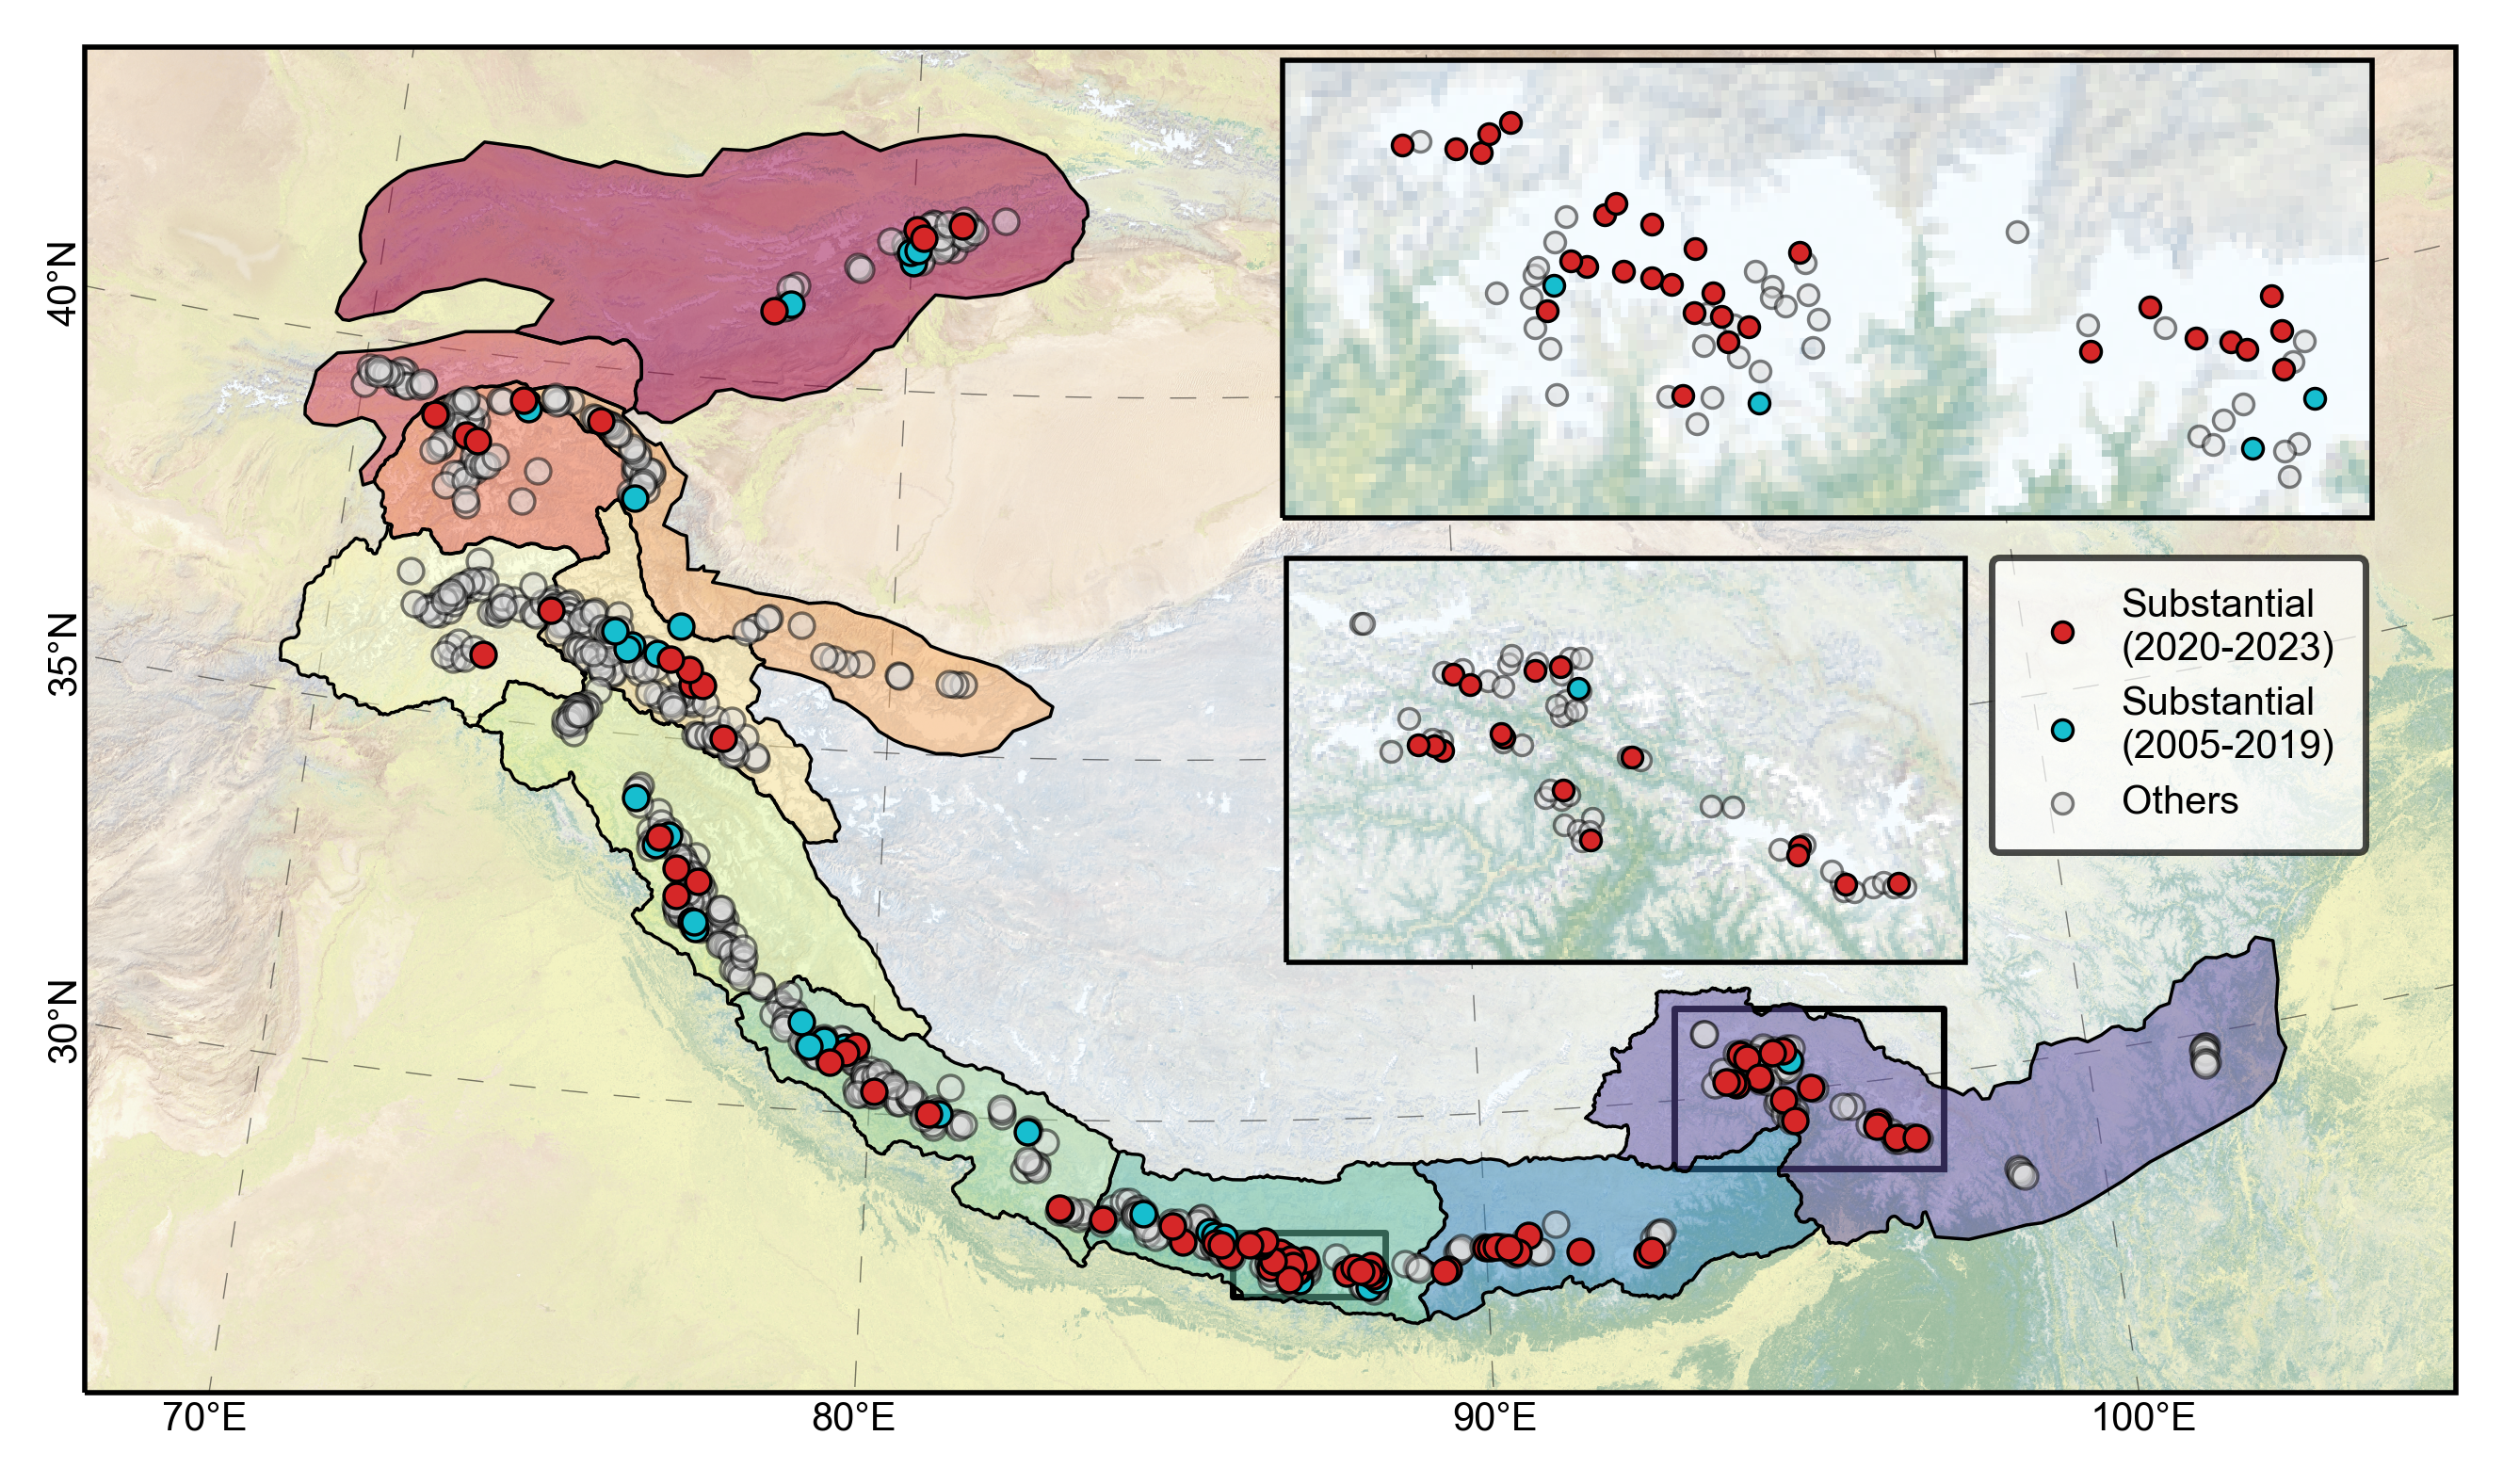

In [30]:
# initiate figure
fig,axs = plt.subplots(figsize=(6.5,6.5), dpi=500, subplot_kw={'projection':projection_shean})

c_today = 'tab:red'
c_yesterday = 'tab:cyan'

# background image
background_im.plot.imshow(rgb='band', ax=axs, zorder=1)

# o2region boundaries, adding colors along the way
# o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.1,
#                     transform=projection_esri, zorder=3)
# o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5,
#                      transform=projection_esri, zorder=3)

# new subregion boundaries
subregion_gdf.plot(ax=axs, edgecolor='none', color=subregion_gdf['colors'], alpha=0.5,
                    transform=projection_esri, zorder=3)
subregion_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5,
                     transform=projection_esri, zorder=3)

# add glaciers with segments that had >5% in past in orange
# df_to_use = df_segments_gte5
rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(rgi_substantial_nottoday)]
gdf_points1 = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
gdf_points1.plot(ax=axs, color=c_yesterday, edgecolor='black', markersize=15, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)

# add glaciers with segments that have >5% water today, in red
# df_to_use = df_segments_gte5
rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(rgi_substantial_today)]
gdf_points2 = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
gdf_points2.plot(ax=axs, color=c_today, edgecolor='black', markersize=15, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)

# add all other glaciers in light gray
rgi_plot2 = rgi_gdf[~rgi_gdf['rgi_id'].isin(rgi_substantial_all)]
gdf_points3 = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot2['cenlon'],rgi_plot2['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
gdf_points3.plot(ax=axs, color='gainsboro', edgecolor='black', markersize=15, linewidth=0.5,
                alpha=0.5, zorder=3, transform=projection_esri)

# axis limits, etc
axs.set_xlim(xlims_main)
axs.set_ylim(ylims_main)
axs.set_title("", size=6)

# add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([30, 35, 40])

### inset axis to zoom in on everest region
xs = (92000,330000)
ys = (-950000,-850000)
ax_ev = axs.inset_axes( (0.49, 0.65 , 0.49, 0.34), projection=projection_shean,
                      xlim=xs, ylim=ys)
background_im.plot.imshow(rgb='band', ax=ax_ev, zorder=1)
gdf_points1.plot(ax=ax_ev, color=c_yesterday, edgecolor='black', markersize=10, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)
gdf_points2.plot(ax=ax_ev, color=c_today, edgecolor='black', markersize=10, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)
gdf_points3.plot(ax=ax_ev, color='gainsboro', edgecolor='black', markersize=10, linewidth=0.5,
                alpha=0.5, zorder=3, transform=projection_esri)
ax_ev.set_title("")

rect = box(xs[0], ys[0], xs[1], ys[1])
axs.plot(*rect.exterior.xy, linewidth=1, color='black')

### inset axis to zoom in on eastern china/tibet region
xs = (780000,1200000)
ys = (-750000,-500000)
ax_ec = axs.inset_axes( (0.5, 0.32, 0.3, 0.3), projection=projection_shean,
                      xlim=xs, ylim=ys)
background_im.plot.imshow(rgb='band', ax=ax_ec, zorder=1)
gdf_points2.plot(ax=ax_ec, color=c_today, edgecolor='black', markersize=10, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri, label="Substantial\n(2020-2023)")
gdf_points1.plot(ax=ax_ec, color=c_yesterday, edgecolor='black', markersize=10, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri, label="Substantial\n(2005-2019)")
gdf_points3.plot(ax=ax_ec, color='gainsboro', edgecolor='black', markersize=10, linewidth=0.5,
                alpha=0.5, zorder=3, transform=projection_esri, label="Others")
ax_ec.set_title("")

rect = box(xs[0], ys[0], xs[1], ys[1])
axs.plot(*rect.exterior.xy, linewidth=1, color='black')

# make legend, using points from ax_ec
ax_ec.legend(framealpha=0.7, fontsize=6, loc="upper left", borderpad=0.8, handletextpad=0.5,
             labelspacing=0.5, bbox_to_anchor=(1.01,1.05), edgecolor='black')

save=1
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','Substantial Glaciers',f'base.png'),
                transparent=True, bbox_inches='tight', dpi=500)

In [32]:
### lets figure out what are the common factors for these
### segments that have developed substantial SGL cover
# df_segments_0, df_segments_gte1, df_segments_gte5, df_segments_510, df_segments_gte10
background_df = df_segments_0
foreground_df = df_segments_gte5

background_df = df_segments_substantial_never
foreground_df = df_segments_substantial_all

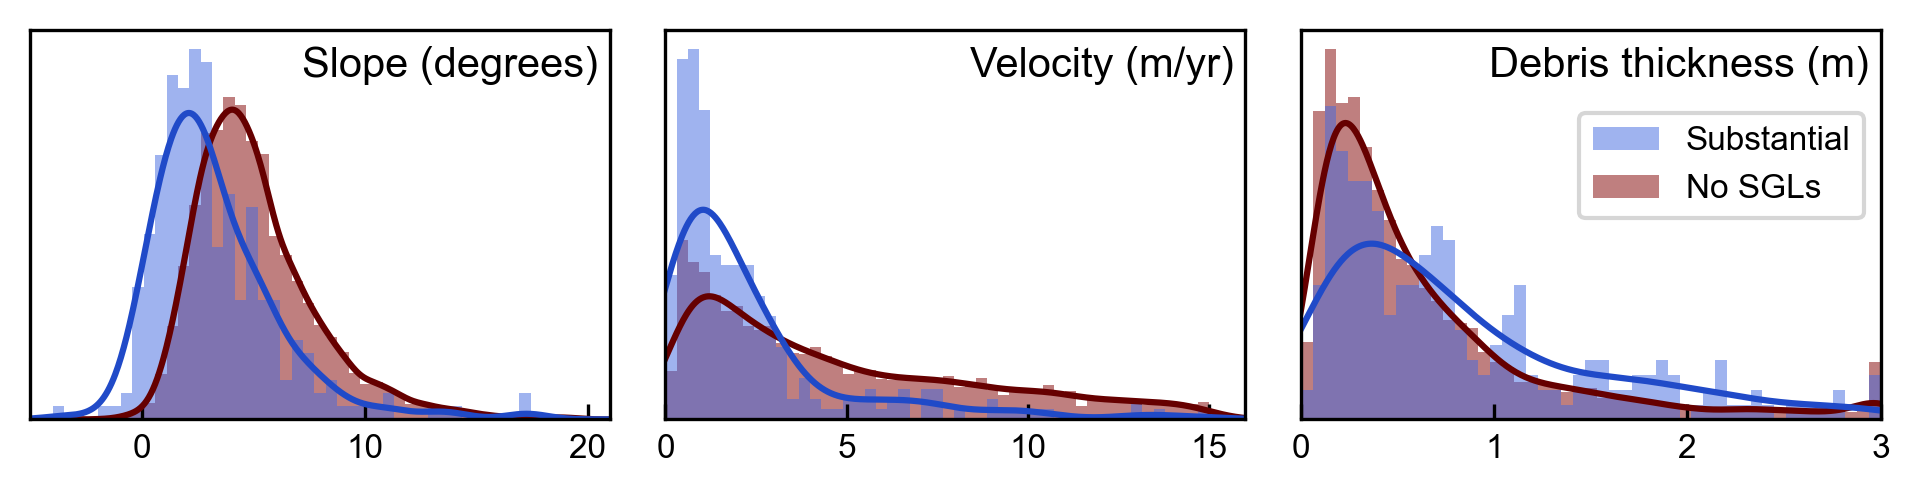

In [61]:
# 3 subplots all together

# define colors
colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
colors_to_use = ['maroon', 'royalblue', '']
c1 = colors_to_use[0]
c2 = colors_to_use[-2]
alpha=0.5

# initiate figure
fig,axs = plt.subplots(1,3, figsize=(6.5,1.75), dpi=300)
ax1,ax2,ax3 = [axs[0], axs[1], axs[2]]


### slope on ax1
d='slope'
bins = np.linspace(-5,20,50) 
df1 = background_df[d][ (background_df[d]>=min(bins)) & (background_df[d]<=max(bins)) ]
df2 = foreground_df[d][ (foreground_df[d]>=min(bins)) & (foreground_df[d]<=max(bins)) ]

# histograms
df1.plot(ax=ax1, kind="hist", density=True, bins=bins, label='No SGLs',
                     color=adjust_lightness(c1,1.0), alpha=alpha, zorder=1)
df2.plot(ax=ax1, kind="hist", density=True, bins=bins, label='>5% SGLs',
                     color=adjust_lightness(c2,1.0), alpha=alpha, zorder=1)
# kdes
df1.plot(ax=ax1, kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
df2.plot(ax=ax1, kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")
ax1.set_xlim(min(bins), max(bins)+1)
ax1.text(0.98, 0.88, 'Slope (degrees)', ha='right', transform=ax1.transAxes )
# ax1.set_xlabel('Slope (degrees)', fontsize=8, labelpad=1 )


### velocity on ax2
d='velocity'
bins = np.linspace(0,15, 50) 
df1 = background_df[d][ (background_df[d]>=min(bins)) & (background_df[d]<=max(bins)) ]
df2 = foreground_df[d][ (foreground_df[d]>=min(bins)) & (foreground_df[d]<=max(bins)) ]

# histograms
df1.plot(ax=ax2, kind="hist", density=True, bins=bins, label='No SGLs',
                     color=adjust_lightness(c1,1.0), alpha=alpha, zorder=1)
df2.plot(ax=ax2, kind="hist", density=True, bins=bins, label='>5% SGLs',
                     color=adjust_lightness(c2,1.0), alpha=alpha, zorder=1)
# kdes
df1.plot(ax=ax2, kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
df2.plot(ax=ax2, kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")
ax2.set_xlim(min(bins), max(bins)+1)
ax2.text(0.98, 0.88, 'Velocity (m/yr)', ha='right', transform=ax2.transAxes )
# ax2.set_xlabel('Velocity (m/yr)', fontsize=8, labelpad=1 )


### debris thickness on ax3
d='debris_thickness'
bins = np.linspace(0,3, 50)
df1 = background_df[d][ (background_df[d]>=min(bins)) & (background_df[d]<=max(bins)) ]
df2 = foreground_df[d][ (foreground_df[d]>=min(bins)) & (foreground_df[d]<=max(bins)) ]

# histograms
df1.plot(ax=ax3, kind="hist", density=True, bins=bins, label='No SGLs',
                     color=adjust_lightness(c1,1.0), alpha=alpha, zorder=1)
df2.plot(ax=ax3, kind="hist", density=True, bins=bins, label='Substantial',
                     color=adjust_lightness(c2,1.0), alpha=alpha, zorder=1)
# kdes
df1.plot(ax=ax3, kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
df2.plot(ax=ax3, kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")
ax3.set_xlim(min(bins), max(bins))
ax3.text(0.98, 0.88, 'Debris thickness (m)', ha='right', transform=ax3.transAxes )
# ax3.set_xlabel('Debris thickness (m)', fontsize=8, labelpad=1 )

for ax in [ax1,ax2,ax3]:
    # ax.legend()
    ax.set_yticks([])
    ax.set_ylabel('')
    # ax.grid()
    ax.tick_params(axis="both",direction="in", labelsize=8)
ax3.legend(loc='upper right', fontsize=8, bbox_to_anchor=(1,0.83), reverse=True )
plt.tight_layout()

save = 1
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','topographic drivers',f'drivers.png'),
                transparent=False, bbox_inches='tight', dpi=300)

In [13]:
# # zoom in on everest region
# # initiate figure
# fig,axs = plt.subplots(figsize=(2,1), dpi=300, subplot_kw={'projection':projection_shean})

# # background image
# background_im.plot.imshow(rgb='band', ax=axs, zorder=1)

# # add glaciers with segments that have >5% water, in red
# df_to_use = df_segments_gte5
# rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(df_to_use['rgi_id'])]
# gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
# gdf_points.plot(ax=axs, color='tab:blue', edgecolor='black', markersize=5, linewidth=0.5, alpha=1, zorder=4,
#                transform=projection_esri)

# # add all other glaciers in light gray
# rgi_plot = rgi_gdf[~rgi_gdf['rgi_id'].isin(df_to_use['rgi_id'])]
# gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
# gdf_points.plot(ax=axs, color='gainsboro', edgecolor='black', markersize=5, linewidth=0.5,
#                 alpha=0.5, zorder=3, transform=projection_esri)

# # axis limits, etc
# axs.set_xlim(92000,330000)
# axs.set_ylim(-980000,-820000)
# axs.set_title("")

# eastern china region
# axs.set_xlim(780000,1200000)
# axs.set_ylim(-750000,-500000)


In [15]:
# # 4 subplots all together

# # define colors
# colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
# c1 = colors_to_use[0]
# c2 = colors_to_use[-2]

# # initiate figure
# fig,axs = plt.subplots(2,2, figsize=(6.5,4))
# ax1,ax2,ax3,ax4 = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]


# ### slope on ax1
# d='slope'
# bins = np.linspace(-5,20,50) 
# df1 = background_df[d][ (background_df[d]>=min(bins)) & (background_df[d]<=max(bins)) ]
# df2 = foreground_df[d][ (foreground_df[d]>=min(bins)) & (foreground_df[d]<=max(bins)) ]

# # histograms
# df1.plot(ax=ax1, kind="hist", density=True, bins=bins, label='No SGLs',
#                      color=c1, alpha=0.7, zorder=1)
# df2.plot(ax=ax1, kind="hist", density=True, bins=bins, label='>5% SGLs',
#                      color=c2, alpha=0.7, zorder=1)
# # kdes
# df1.plot(ax=ax1, kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
# df2.plot(ax=ax1, kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")
# ax1.set_xlim(min(bins), max(bins))
# ax1.text(0.95, 0.9, 'Slope (degrees)', ha='right', transform=ax1.transAxes )


# ### velocity on ax2
# d='velocity'
# bins = np.linspace(0,15, 50) 
# df1 = background_df[d][ (background_df[d]>=min(bins)) & (background_df[d]<=max(bins)) ]
# df2 = foreground_df[d][ (foreground_df[d]>=min(bins)) & (foreground_df[d]<=max(bins)) ]

# # histograms
# df1.plot(ax=ax2, kind="hist", density=True, bins=bins, label='No SGLs',
#                      color=c1, alpha=0.7, zorder=1)
# df2.plot(ax=ax2, kind="hist", density=True, bins=bins, label='>5% SGLs',
#                      color=c2, alpha=0.7, zorder=1)
# # kdes
# df1.plot(ax=ax2, kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
# df2.plot(ax=ax2, kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")
# ax2.set_xlim(min(bins), max(bins))
# ax2.text(0.95, 0.9, 'Velocity (m/yr)', ha='right', transform=ax2.transAxes )


# ### dhdt on ax3
# d='dhdt_1520'
# bins = np.linspace(-5,2, 50) 
# df1 = background_df[d][ (background_df[d]>=min(bins)) & (background_df[d]<=max(bins)) ]
# df2 = foreground_df[d][ (foreground_df[d]>=min(bins)) & (foreground_df[d]<=max(bins)) ]

# # histograms
# df1.plot(ax=ax3, kind="hist", density=True, bins=bins, label='No SGLs',
#                      color=c1, alpha=0.7, zorder=1)
# df2.plot(ax=ax3, kind="hist", density=True, bins=bins, label='>5% SGLs',
#                      color=c2, alpha=0.7, zorder=1)
# # kdes
# df1.plot(ax=ax3, kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
# df2.plot(ax=ax3, kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")
# ax3.set_xlim(min(bins), max(bins))
# ax3.text(0.95, 0.9, 'dh/dt (m/yr)', ha='right', transform=ax3.transAxes )



# ### debris thickness on ax4
# d='debris_thickness'
# bins = np.linspace(0,5, 50)
# df1 = background_df[d][ (background_df[d]>=min(bins)) & (background_df[d]<=max(bins)) ]
# df2 = foreground_df[d][ (foreground_df[d]>=min(bins)) & (foreground_df[d]<=max(bins)) ]

# # histograms
# df1.plot(ax=ax4, kind="hist", density=True, bins=bins, label='No SGLs',
#                      color=c1, alpha=0.7, zorder=1)
# df2.plot(ax=ax4, kind="hist", density=True, bins=bins, label='>5% SGLs',
#                      color=c2, alpha=0.7, zorder=1)
# # kdes
# df1.plot(ax=ax4, kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
# df2.plot(ax=ax4, kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")
# ax4.set_xlim(min(bins), max(bins))
# ax4.text(0.95, 0.9, 'Debris thickness (m)', ha='right', transform=ax4.transAxes )



# for ax in [ax1,ax2,ax3,ax4]:
#     # ax.legend()
#     ax.set_yticks([])
#     ax.set_ylabel('')
#     ax.tick_params(axis="both",direction="in")
    
# plt.tight_layout()

C:\Users\lzell\AppData\Local\Temp\ipykernel_2356\1804893161.py:24: RuntimeWarning: invalid value encountered in divide
  ax1.bar(bins[:-1], hist_sub[0]/hist_all[0]*100, align='edge', color=c2, width=bins[1]-bins[0])


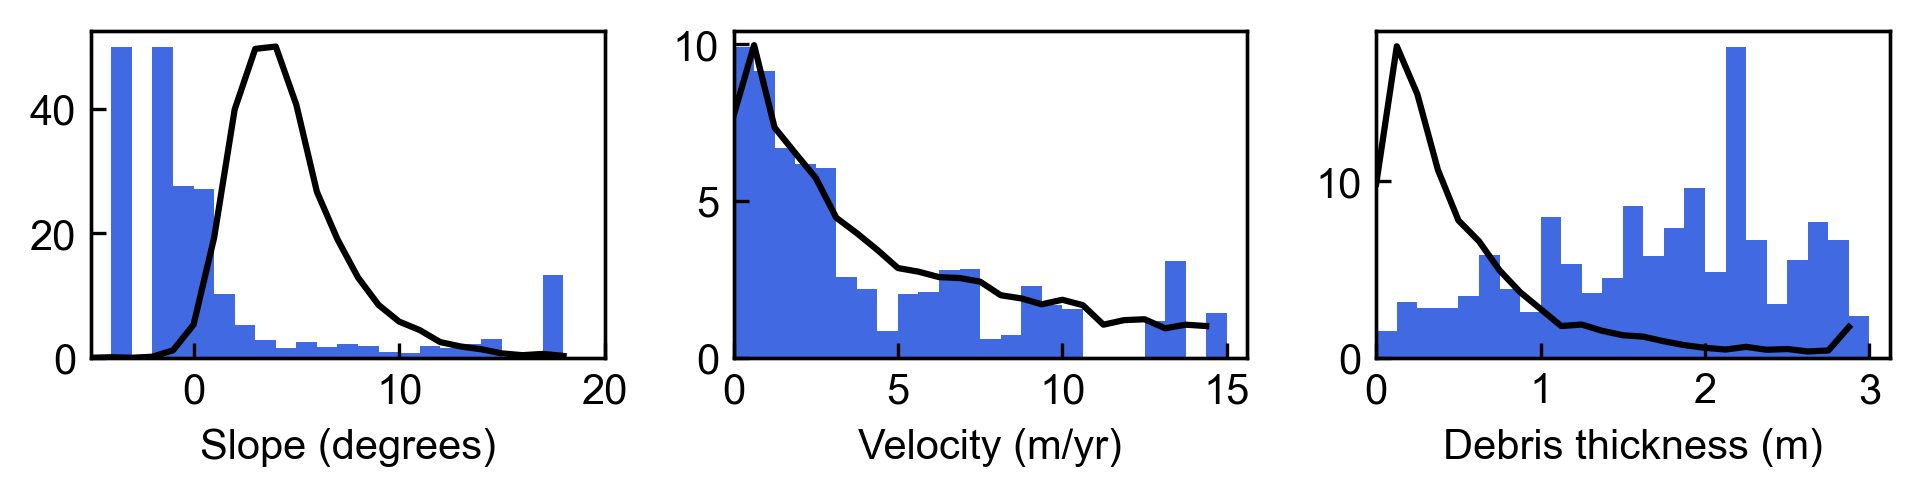

In [63]:
# what about: for each bin, the proportion of segments that have had substantial water at some point


# define colors
colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
colors_to_use = ['maroon', 'royalblue', '']
c1 = colors_to_use[0]
c2 = colors_to_use[-2]
alpha=0.5
nbins=25

# initiate figure
fig,axs = plt.subplots(1,3, figsize=(6.5,1.75), dpi=300)
ax1,ax2,ax3 = [axs[0], axs[1], axs[2]]


### slope on ax1
d='slope'
bins = np.linspace(-5,19,nbins) 

# histograms
hist_all = np.histogram(df_segments_all[d], bins=bins)
hist_sub = np.histogram(foreground_df[d], bins=bins)
ax1.bar(bins[:-1], hist_sub[0]/hist_all[0]*100, align='edge', color=c2, width=bins[1]-bins[0])
ax1.set_xlim(min(bins), max(bins)+bins[1]-bins[0])
# ax1.text(0.98, 0.88, 'Slope (degrees)', ha='right', transform=ax1.transAxes )
ax1.set_xlabel('Slope (degrees)')

# twinx to show count
ax1t = ax1.twinx()
ax1t.plot(bins[:-1],hist_all[0],c='black')
ax1t.set_ylim(0,)




### velocity on ax2
d='velocity'
bins = np.linspace(0,15, nbins) 
# histograms
hist_all = np.histogram(df_segments_all[d], bins=bins)
hist_sub = np.histogram(foreground_df[d], bins=bins)
ax2.bar(bins[:-1], hist_sub[0]/hist_all[0]*100, align='edge', color=c2, width=bins[1]-bins[0])
ax2.set_xlim(min(bins), max(bins)+bins[1]-bins[0])
# ax2.text(0.98, 0.88, 'Velocity (m/yr)', ha='right', transform=ax2.transAxes )
ax2.set_xlabel('Velocity (m/yr)')

# twinx to show count
ax2t = ax2.twinx()
ax2t.plot(bins[:-1],hist_all[0],c='black')
ax2t.set_ylim(0,)


### debris thickness on ax3
d='debris_thickness'
bins = np.linspace(0,3, nbins)
# histograms
hist_all = np.histogram(df_segments_all[d], bins=bins)
hist_sub = np.histogram(foreground_df[d], bins=bins)
temp = pd.DataFrame()
ax3.bar(bins[:-1], hist_sub[0]/hist_all[0]*100, align='edge', color=c2, width=bins[1]-bins[0], label='SGL Probability')
ax3.set_xlim(min(bins), max(bins)+bins[1]-bins[0])
ax3.set_xlabel('Debris thickness (m)')

# twinx to show count
ax3t = ax3.twinx()
ax3t.plot(bins[:-1],hist_all[0],c='black')
ax3t.set_ylim(0,)


for ax in [ax1,ax2,ax3]:
    # ax.legend()
    # ax.set_yticks([])
    ax.set_ylabel('')
    ax.tick_params(axis="both",direction="in")
    
for ax in [ax1t,ax2t,ax3t]:
    ax.tick_params(axis="both",direction="in")
    ax.set_yticks([])
# ax3.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1,0.15) )
plt.tight_layout()

In [38]:
hist_all

(array([ 479, 1077,  979,  789,  595,  477,  399,  313,  283,  200,  156,
         116,  106,   94,   98,   65,   78,   51,   45,   42,   31,   27,
          37,   33,   28,   25,   22,   25,   34,   97,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0], dtype=int64),
 array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
        0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
        1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
        1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
        2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
        2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
        3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
        3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
        4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
        4.59183673, 4.69387755, 4.79591

In [40]:
bins

array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
       0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
       1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
       1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
       2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
       2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
       3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
       3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
       4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
       4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ])

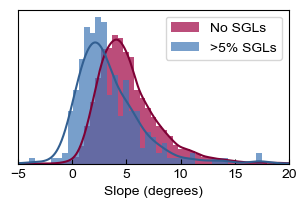

In [19]:
d = 'slope'

# define what bins to use, subset data to only this range
bins = np.linspace(-5,20, 50) 
df1 = background_df[d]
df1 = df1[ (df1>=min(bins)) & (df1<=max(bins)) ]
df2 = foreground_df[d]
df2 = df2[ (df2>=min(bins)) & (df2<=max(bins)) ]

# define colors
colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
c1 = colors_to_use[0]
c2 = colors_to_use[-2]

fig,axs = plt.subplots(figsize=(3.5,2))

# histograms
df1.plot(kind="hist", density=True, bins=bins, label='No SGLs',
                     color=c1, alpha=0.7, zorder=1)
df2.plot(kind="hist", density=True, bins=bins, label='>5% SGLs',
                     color=c2, alpha=0.7, zorder=1)

# kdes
df1.plot(kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
df2.plot(kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")

axs.legend()
axs.set_xlim(min(bins), max(bins))
axs.set_yticks([])
axs.set_xlabel('Slope (degrees)')
axs.set_ylabel('')
axs.tick_params(axis="both",direction="in")
# axs.set_ylabel('Normalized Frequency')

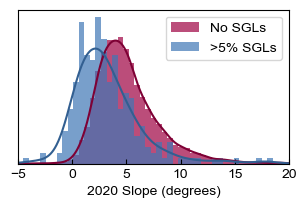

In [20]:
d = 's2020'

# define what bins to use, subset data to only this range
bins = np.linspace(-5,20, 50) 
df1 = background_df[d]
df1 = df1[ (df1>=min(bins)) & (df1<=max(bins)) ]
df2 = foreground_df[d]
df2 = df2[ (df2>=min(bins)) & (df2<=max(bins)) ]

# define colors
colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
c1 = colors_to_use[0]
c2 = colors_to_use[-2]

fig,axs = plt.subplots(figsize=(3.5,2))

# histograms
df1.plot(kind="hist", density=True, bins=bins, label='No SGLs',
                     color=c1, alpha=0.7, zorder=1)
df2.plot(kind="hist", density=True, bins=bins, label='>5% SGLs',
                     color=c2, alpha=0.7, zorder=1)

# kdes
df1.plot(kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
df2.plot(kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")

axs.legend()
axs.set_xlim(min(bins), max(bins))
axs.set_yticks([])
axs.set_xlabel('2020 Slope (degrees)')
axs.set_ylabel('')
axs.tick_params(axis="both",direction="in")
# axs.set_ylabel('Normalized Frequency')

In [21]:
# d = 'sdecrease'
# background_df[d] = background_df['slope']-background_df['s2020']
# foreground_df[d] = foreground_df['slope']-foreground_df['s2020']

# # define what bins to use, subset data to only this range
# bins = np.linspace(-2,2, 50) 
# df1 = background_df[d]
# df1 = df1[ (df1>=min(bins)) & (df1<=max(bins)) ]
# df2 = foreground_df[d]
# df2 = df2[ (df2>=min(bins)) & (df2<=max(bins)) ]

# # define colors
# colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
# c1 = colors_to_use[0]
# c2 = colors_to_use[-2]

# fig,axs = plt.subplots(figsize=(3.5,2), dpi=300)

# # histograms
# df1.plot(kind="hist", density=True, bins=bins, label='No SGLs',
#                      color=c1, alpha=0.7, zorder=1)
# df2.plot(kind="hist", density=True, bins=bins, label='>5% SGLs',
#                      color=c2, alpha=0.7, zorder=1)

# # kdes
# df1.plot(kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
# df2.plot(kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")

# axs.legend()
# axs.set_xlim(min(bins), max(bins))
# axs.set_yticks([])
# axs.set_xlabel('Slope (degrees)')
# axs.set_ylabel('')
# axs.tick_params(axis="both",direction="in")
# # axs.set_ylabel('Normalized Frequency')

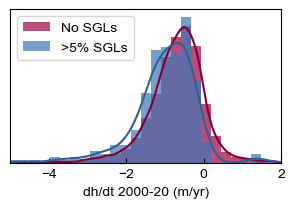

In [22]:
d = 'dhdt_0020'

# define what bins to use, subset data to only this range
bins = np.linspace(-5,2,28) 
df1 = background_df[d]
df1 = df1[ (df1>=min(bins)) & (df1<=max(bins)) ]
df2 = foreground_df[d]
df2 = df2[ (df2>=min(bins)) & (df2<=max(bins)) ]

# define colors
colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
c1 = colors_to_use[0]
c2 = colors_to_use[-2]

fig,axs = plt.subplots(figsize=(3.5,2))

# histograms
df1.plot(kind="hist", density=True, bins=bins, label='No SGLs',
                     color=c1, alpha=0.7, zorder=1)
df2.plot(kind="hist", density=True, bins=bins, label='>5% SGLs',
                     color=c2, alpha=0.7, zorder=1)

# kdes
df1.plot(kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
df2.plot(kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")

axs.legend()
axs.set_xlim(min(bins), max(bins))
axs.set_yticks([])
axs.set_xlabel('dh/dt 2000-20 (m/yr)')
axs.set_ylabel('')
axs.tick_params(axis="both",direction="in")
# axs.set_ylabel('Normalized Frequency')

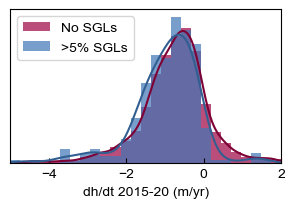

In [23]:
d = 'dhdt_1520'

# define what bins to use, subset data to only this range
bins = np.linspace(-5,2,28) 
df1 = background_df[d]
df1 = df1[ (df1>=min(bins)) & (df1<=max(bins)) ]
df2 = foreground_df[d]
df2 = df2[ (df2>=min(bins)) & (df2<=max(bins)) ]

# define colors
colors_to_use = plt.cm.Spectral(np.linspace(0, 1, 15))
c1 = colors_to_use[0]
c2 = colors_to_use[-2]

fig,axs = plt.subplots(figsize=(3.5,2))

# histograms
df1.plot(kind="hist", density=True, bins=bins, label='No SGLs',
                     color=c1, alpha=0.7, zorder=1)
df2.plot(kind="hist", density=True, bins=bins, label='>5% SGLs',
                     color=c2, alpha=0.7, zorder=1)

# kdes
df1.plot(kind="kde", color=adjust_lightness(c1,0.8), zorder=2, label="")
df2.plot(kind="kde", color=adjust_lightness(c2,0.8), zorder=2, label="")

axs.legend()
axs.set_xlim(min(bins), max(bins))
axs.set_yticks([])
axs.set_xlabel('dh/dt 2015-20 (m/yr)')
axs.set_ylabel('')
axs.tick_params(axis="both",direction="in")
# axs.set_ylabel('Normalized Frequency')